In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 13:56:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   27C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_masks(directory):
    image_paths = []
    mask_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".png") and not "_mask" in filename:
            image_paths.append(os.path.join(directory, filename))
            mask_paths.append(os.path.join(directory, filename[:-4] + "_mask.png"))
    return image_paths, mask_paths

# Load benign and malignant images and masks
benign_images, benign_masks = load_images_and_masks("./Dataset_BUSI_with_GT/benign/")
malignant_images, malignant_masks = load_images_and_masks("./Dataset_BUSI_with_GT/malignant/")

# Combine benign and malignant images and masks
images = benign_images + malignant_images
masks = benign_masks + malignant_masks

# Split the dataset into training and testing sets
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, masks, img_width, img_height, is_augment=True):
        self.images = images
        self.masks = masks
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        label = Image.open(self.masks[index]).resize((self.img_width, self.img_height))
        label = np.array(label, dtype=np.float32)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                label = cv2.warpAffine(label, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                label = cv2.flip(label, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])

        y_transform = transforms.Compose([
            ToLabel(),
        ])
        img_new = tfms(img_new)
        label = y_transform(label)

        return img_new, label

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, masks_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, masks_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))


Training samples #:  517
Test samples #:  130


In [6]:
class UNetVGG16(nn.Module):
    def __init__(self, n_classes):
        super(UNetVGG16, self).__init__()

        # Load a pretrained ResNet50 model
        vgg16 = models.vgg16(pretrained=True).features

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(vgg16.children())[0:5]))
        self.enc_features2 = nn.Sequential(*(list(vgg16.children())[5:10]))
        self.enc_features3 = nn.Sequential(*(list(vgg16.children())[10:17]))
        self.enc_features4 = nn.Sequential(*(list(vgg16.children())[17:24]))
        self.enc_features5 = nn.Sequential(*(list(vgg16.children())[24:]))

        # Decoder
        self.upconv3 = self._make_up_block(512, 512)
        self.dec3 = self._make_dec_block(1024, 512)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(512, 256)
        self.dec2 = self._make_dec_block(512, 256)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(256, 128)
        self.dec1 = self._make_dec_block(256, 128)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(128, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
   
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        return self.final_conv(x)

model = UNetVGG16(2)
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train loss: 0.5827547284689817
Epoch 1, Test loss: 0.5632229381137424
Epoch 2, Train loss: 0.3773041701678074
Epoch 2, Test loss: 0.3397237757841746
Epoch 3, Train loss: 0.30001895716696075
Epoch 3, Test loss: 0.2501426670286391
Epoch 4, Train loss: 0.2530309937217019
Epoch 4, Test loss: 0.2448100878132714
Epoch 5, Train loss: 0.22757142375815997
Epoch 5, Test loss: 0.2034753445121977
Epoch 6, Train loss: 0.2113453456849763
Epoch 6, Test loss: 0.21109099520577324
Epoch 7, Train loss: 0.19268887061061282
Epoch 7, Test loss: 0.17432664997047848
Epoch 8, Train loss: 0.17361237424792667
Epoch 8, Test loss: 0.17174387474854788
Epoch 9, Train loss: 0.16687123071063648
Epoch 9, Test loss: 0.1560582924220297
Epoch 10, Train loss: 0.15483564906048053
Epoch 10, Test loss: 0.14641244295570585
Epoch 11, Train loss: 0.14408669191779513
Epoch 11, Test loss: 0.1370432178179423
Epoch 12, Train loss: 0.1389839066700502
Epoch 12, Test loss: 0.14421959800852668
Epoch 13, Train loss: 0.1284453015

Epoch 100, Test loss: 0.10021247797542149


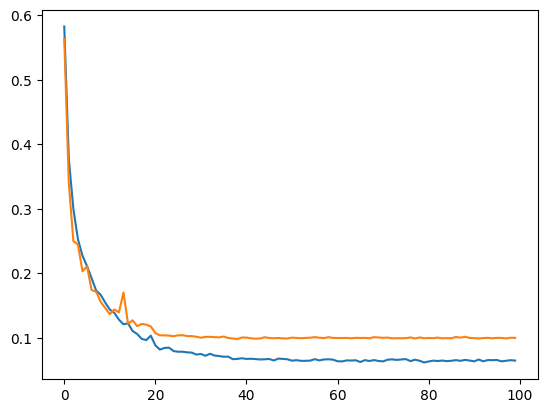

In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, seg_label) in enumerate(train_loader):
        image, seg_label = image.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(image)

        # Calculate loss
        loss = loss_function(output, seg_label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, seg_label in test_loader:
            image, seg_label = image.to(device), seg_label.to(device)
            y_predict = model(image)
            loss = loss_function(y_predict, seg_label)
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/UNetVGG16.pt")

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_526706/3180718297.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


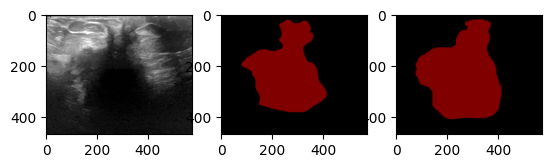

0.7633788681349317
0.8937498748172331
./Dataset_BUSI_with_GT/benign/benign (110).png


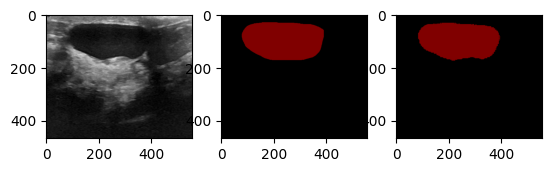

0.9222251377591183
0.9868028531483477
./Dataset_BUSI_with_GT/benign/benign (245).png


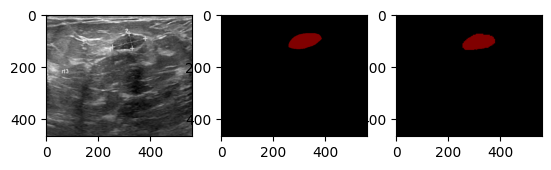

0.8052930056710775
0.9951584093259378
./Dataset_BUSI_with_GT/benign/benign (22).png


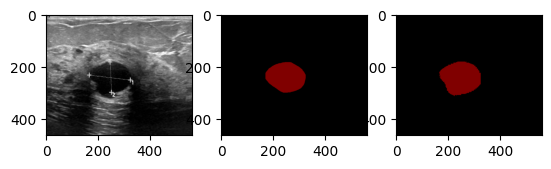

0.873177936171579
0.9919913384805035
./Dataset_BUSI_with_GT/benign/benign (399).png


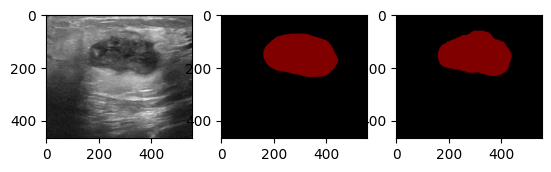

0.89624
0.9827931597171551
./Dataset_BUSI_with_GT/malignant/malignant (133).png


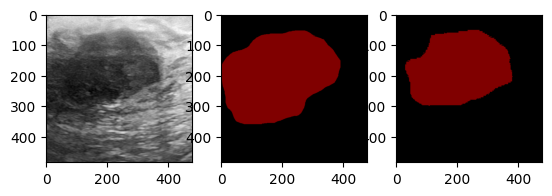

0.737408029793805
0.8618211148951425
./Dataset_BUSI_with_GT/benign/benign (219).png


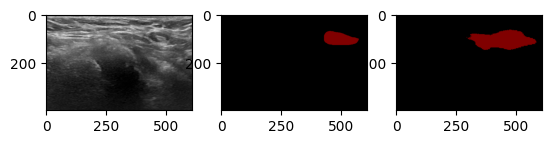

0.396543883583447
0.96041574336072
./Dataset_BUSI_with_GT/benign/benign (427).png


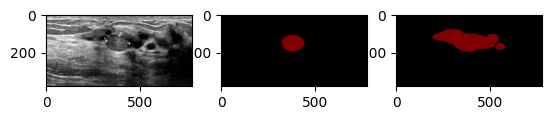

0.3117723156532988
0.9353393641588388
./Dataset_BUSI_with_GT/benign/benign (381).png


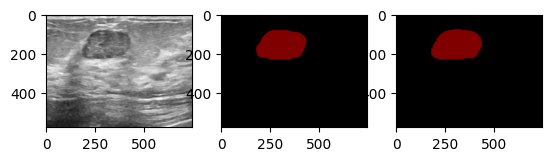

0.9370097670924117
0.994748091297016
./Dataset_BUSI_with_GT/benign/benign (55).png


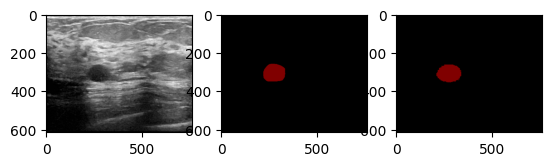

0.8926181406362607
0.9977316816438022
./Dataset_BUSI_with_GT/malignant/malignant (1).png


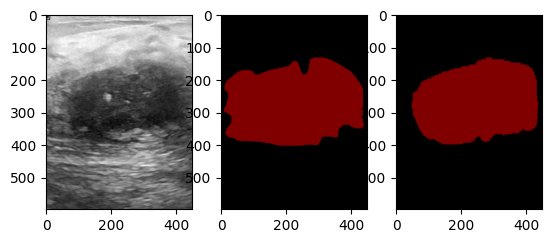

0.8194640189045131
0.910880368258618
./Dataset_BUSI_with_GT/benign/benign (362).png


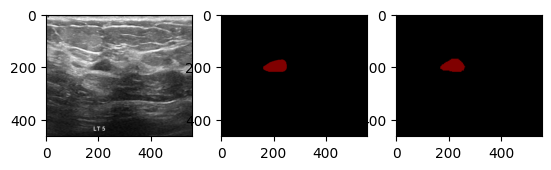

0.7658344283837056
0.9965131841555331
./Dataset_BUSI_with_GT/benign/benign (15).png


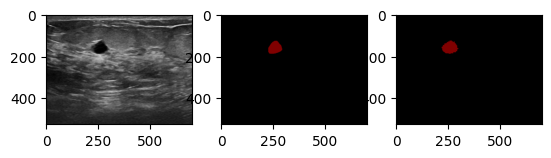

0.8275285594873224
0.9983076149126741
./Dataset_BUSI_with_GT/benign/benign (14).png


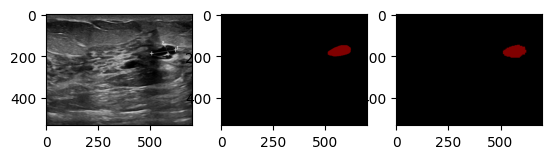

0.8097598170034311
0.9972800684616034
./Dataset_BUSI_with_GT/malignant/malignant (62).png


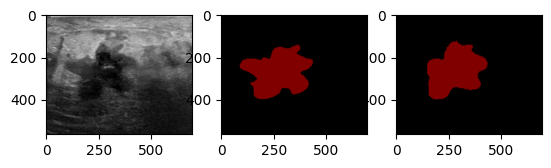

0.8094124122746663
0.9678364185794032
./Dataset_BUSI_with_GT/benign/benign (435).png


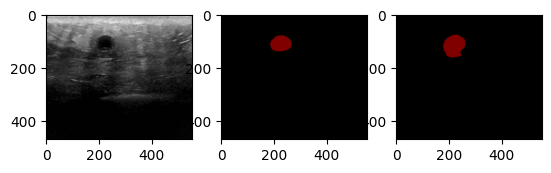

0.6517173874354868
0.9923322858956376
./Dataset_BUSI_with_GT/benign/benign (191).png


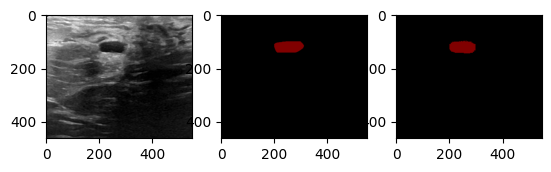

0.8427382053654024
0.9972858950359819
./Dataset_BUSI_with_GT/malignant/malignant (145).png


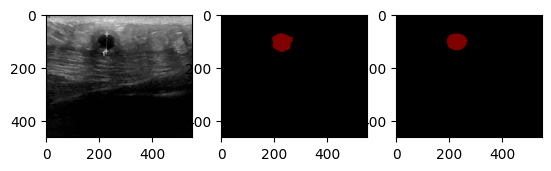

0.8603508771929824
0.9976160241512327
./Dataset_BUSI_with_GT/benign/benign (335).png


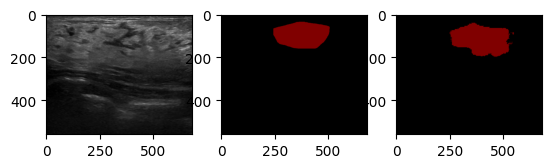

0.6264665140078591
0.9631456073457753
./Dataset_BUSI_with_GT/benign/benign (259).png


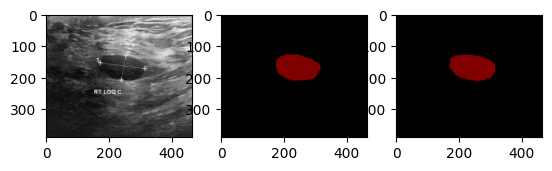

0.9332444626743233
0.9962205876376641
./Dataset_BUSI_with_GT/benign/benign (45).png


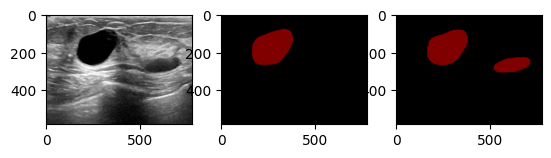

0.693316677076827
0.9684003527757252
./Dataset_BUSI_with_GT/benign/benign (344).png


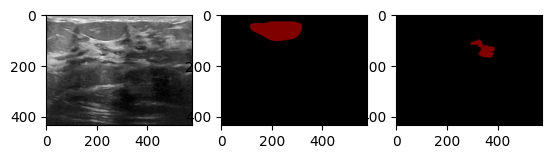

0.0
0.9382040450588838
./Dataset_BUSI_with_GT/benign/benign (199).png


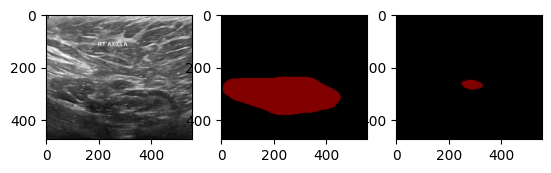

0.04734685515263266
0.8216221607583332
./Dataset_BUSI_with_GT/benign/benign (240).png


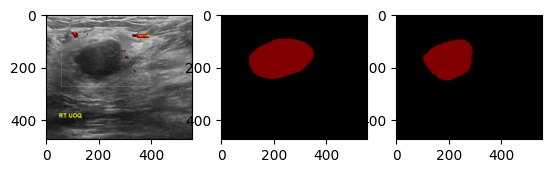

0.7343657146852169
0.9685965782296058
./Dataset_BUSI_with_GT/malignant/malignant (140).png


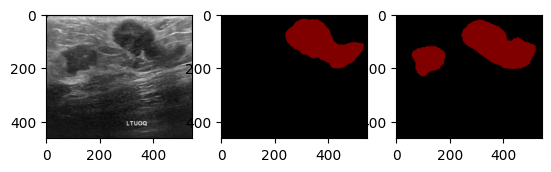

0.6422278385336703
0.9328614233537817
./Dataset_BUSI_with_GT/benign/benign (385).png


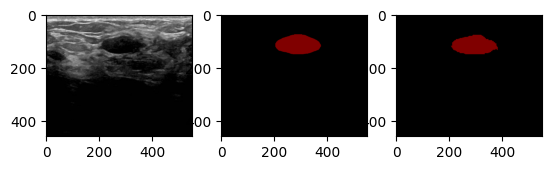

0.8930333530688771
0.9955447416443356
./Dataset_BUSI_with_GT/benign/benign (125).png


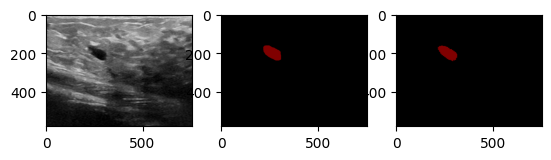

0.8768902675455603
0.9985316051752245
./Dataset_BUSI_with_GT/benign/benign (72).png


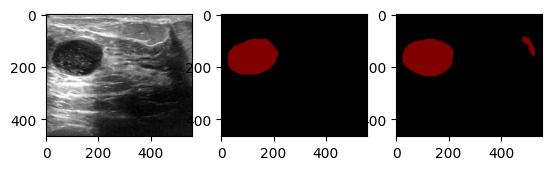

0.8266087316366646
0.982470819562398
./Dataset_BUSI_with_GT/malignant/malignant (56).png


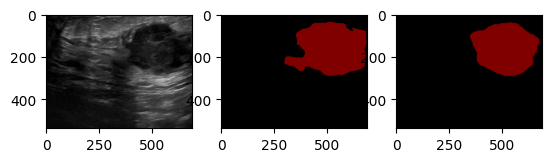

0.8172809264001781
0.9579904
./Dataset_BUSI_with_GT/benign/benign (196).png


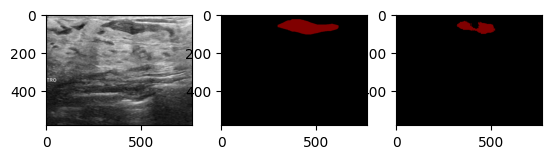

0.47897838899803535
0.9817926337518251
./Dataset_BUSI_with_GT/malignant/malignant (120).png


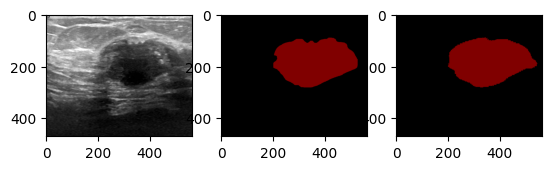

0.9270519937285479
0.9844436914040439
./Dataset_BUSI_with_GT/benign/benign (346).png


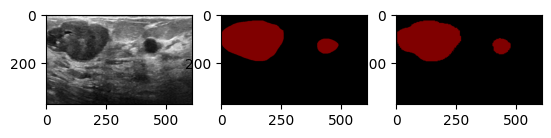

0.9147619168421319
0.9824516506416116
./Dataset_BUSI_with_GT/benign/benign (139).png


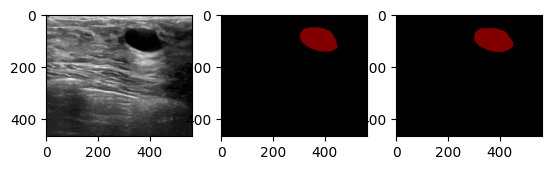

0.9175839170381151
0.9964245827693303
./Dataset_BUSI_with_GT/malignant/malignant (59).png


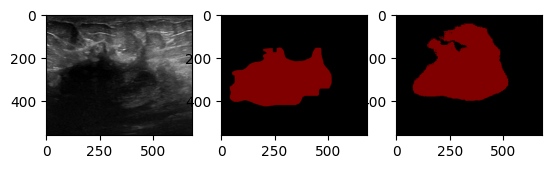

0.5933376299041327
0.836611630970607
./Dataset_BUSI_with_GT/malignant/malignant (8).png


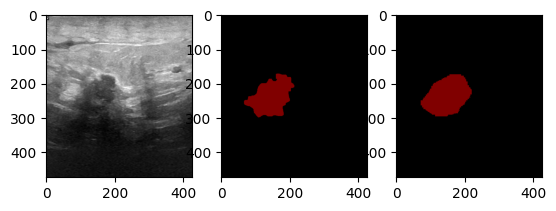

0.8268485506123082
0.9882932452968611
./Dataset_BUSI_with_GT/benign/benign (319).png


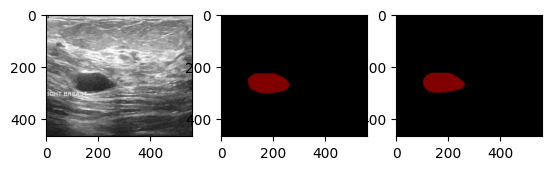

0.9210036263843967
0.9968031476699865
./Dataset_BUSI_with_GT/benign/benign (303).png


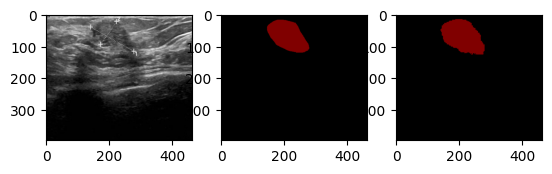

0.8578242524307467
0.9911389076273996
./Dataset_BUSI_with_GT/benign/benign (434).png


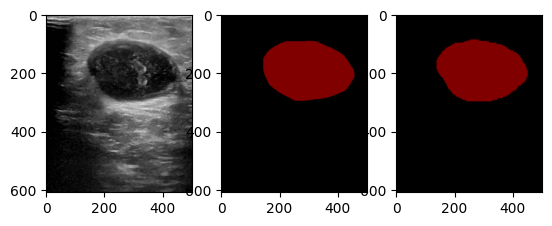

0.9399872436653202
0.9878935568768886
./Dataset_BUSI_with_GT/benign/benign (28).png


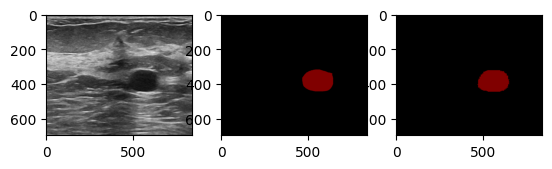

0.9063745019920318
0.9967705619010873
./Dataset_BUSI_with_GT/benign/benign (294).png


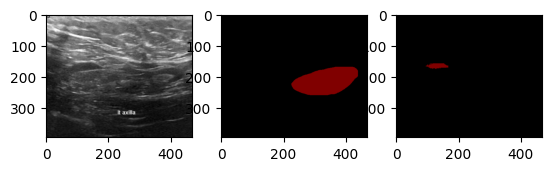

0.0
0.9195501823731235
./Dataset_BUSI_with_GT/benign/benign (122).png


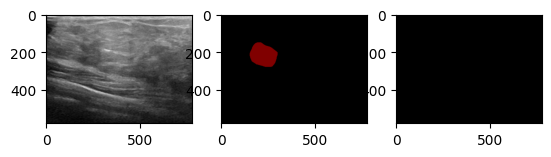

0.0
0.9682510893465712
./Dataset_BUSI_with_GT/benign/benign (129).png


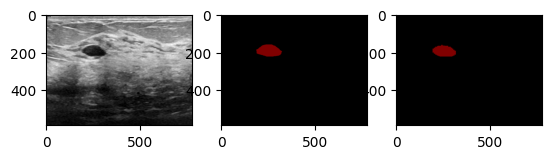

0.8595166163141994
0.9979298140171625
./Dataset_BUSI_with_GT/malignant/malignant (181).png


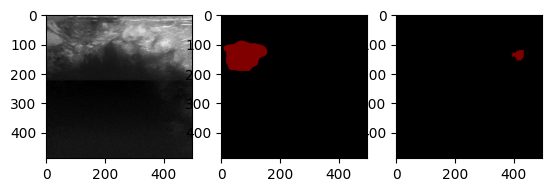

0.0
0.9501352376554408
./Dataset_BUSI_with_GT/benign/benign (171).png


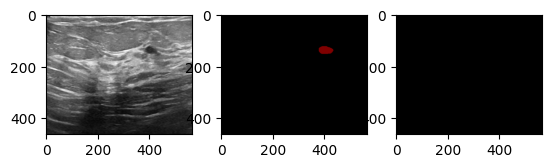

0.0
0.9947759656259302
./Dataset_BUSI_with_GT/malignant/malignant (89).png


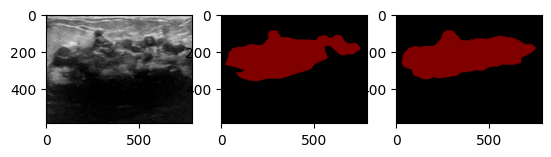

0.831534055274491
0.9440965005508213
./Dataset_BUSI_with_GT/benign/benign (395).png


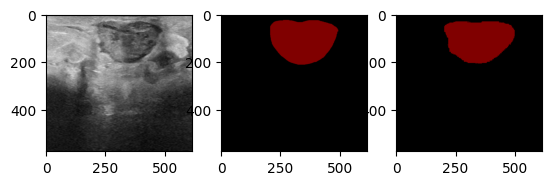

0.9194613821138211
0.9889101265460467
./Dataset_BUSI_with_GT/malignant/malignant (44).png


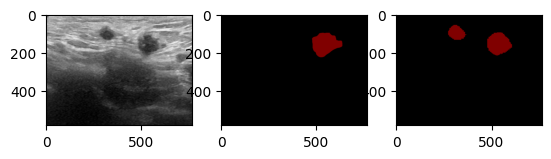

0.5789418433760235
0.9814593107911341
./Dataset_BUSI_with_GT/benign/benign (264).png


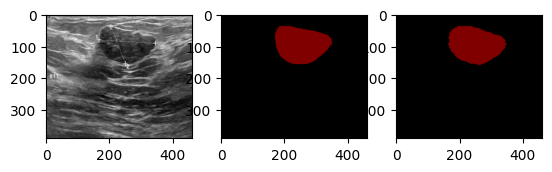

0.9206096048201311
0.9918573583671095
./Dataset_BUSI_with_GT/benign/benign (33).png


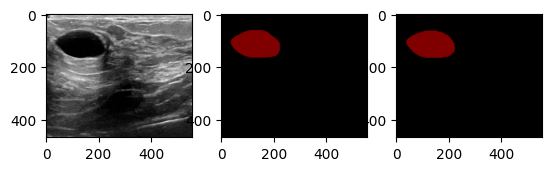

0.9544525360930114
0.9970929639943409
./Dataset_BUSI_with_GT/benign/benign (44).png


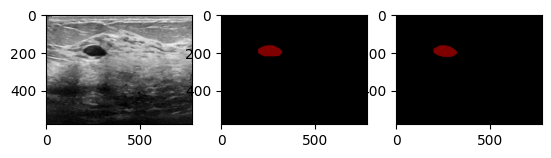

0.9025356576862124
0.9986178688211432
./Dataset_BUSI_with_GT/malignant/malignant (138).png


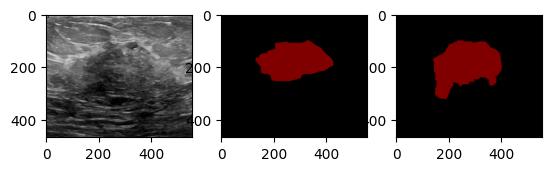

0.7283762138352188
0.9529254084814942
./Dataset_BUSI_with_GT/benign/benign (180).png


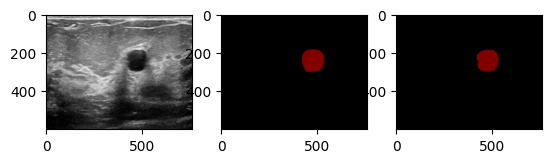

0.9161512027491409
0.9978172189222071
./Dataset_BUSI_with_GT/malignant/malignant (54).png


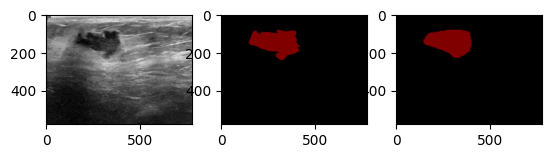

0.8665980795610425
0.9908554502926726
./Dataset_BUSI_with_GT/malignant/malignant (203).png


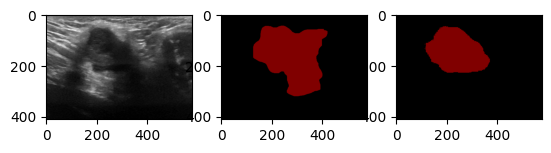

0.5758946558734113
0.8874245267425693
./Dataset_BUSI_with_GT/benign/benign (239).png


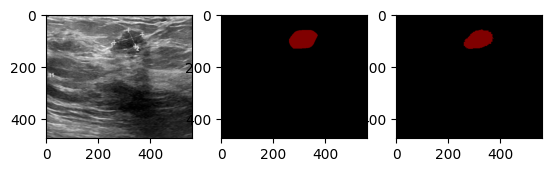

0.8598629093678599
0.9964510964954578
./Dataset_BUSI_with_GT/benign/benign (23).png


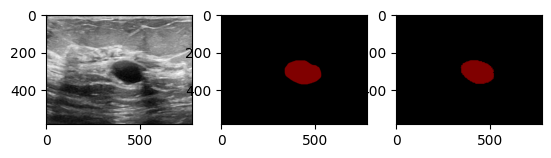

0.8765515802649421
0.9945878586944095
./Dataset_BUSI_with_GT/benign/benign (398).png


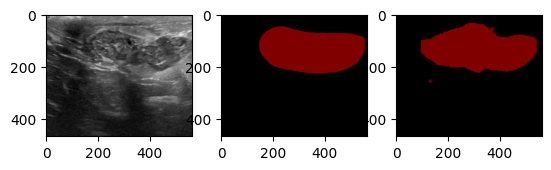

0.7895877857900644
0.9356584372781427
./Dataset_BUSI_with_GT/benign/benign (277).png


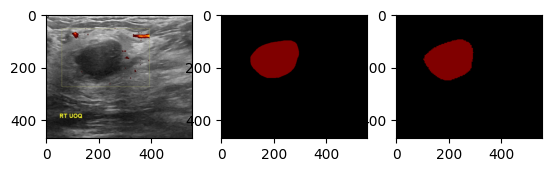

0.9123666498786686
0.9920527161524184
./Dataset_BUSI_with_GT/benign/benign (235).png


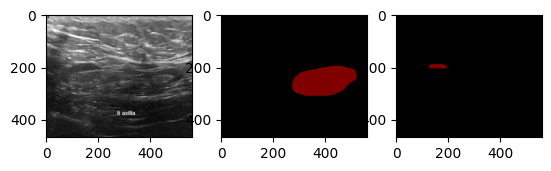

0.0
0.9128663003663003
./Dataset_BUSI_with_GT/benign/benign (334).png


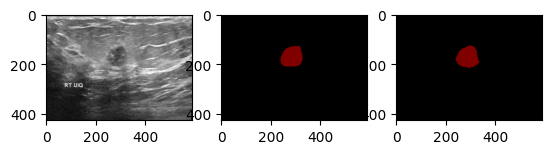

0.8702594810379242
0.9965544799915187
./Dataset_BUSI_with_GT/benign/benign (217).png


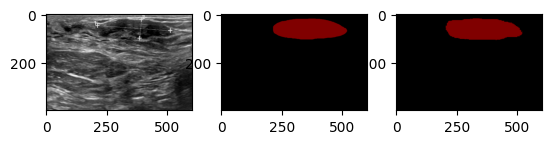

0.8938620599397985
0.9888546848803013
./Dataset_BUSI_with_GT/malignant/malignant (52).png


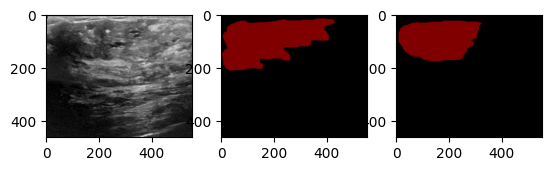

0.6612059951202509
0.915663916047511
./Dataset_BUSI_with_GT/benign/benign (365).png


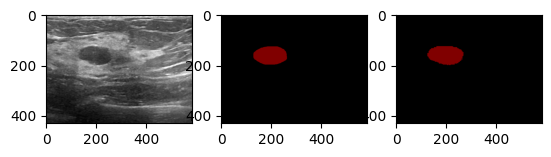

0.8827402957486137
0.9958264974239415
./Dataset_BUSI_with_GT/benign/benign (409).png


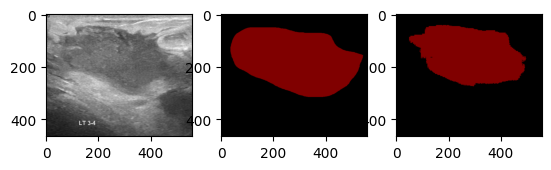

0.7172772196357102
0.8540851007772362
./Dataset_BUSI_with_GT/benign/benign (273).png


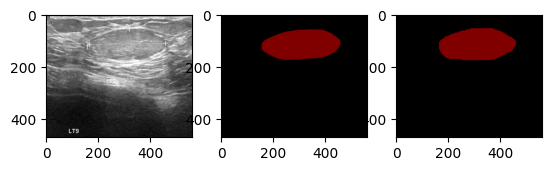

0.920877546146235
0.9901591343093571
./Dataset_BUSI_with_GT/benign/benign (153).png


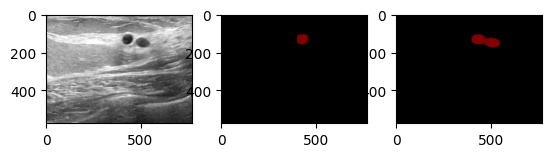

0.3919179913831526
0.9907080750981861
./Dataset_BUSI_with_GT/benign/benign (400).png


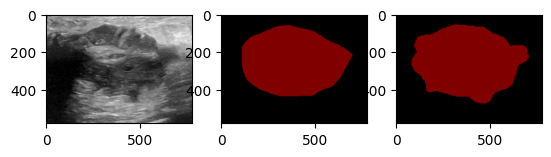

0.9026054219325496
0.9373865476561052
./Dataset_BUSI_with_GT/malignant/malignant (33).png


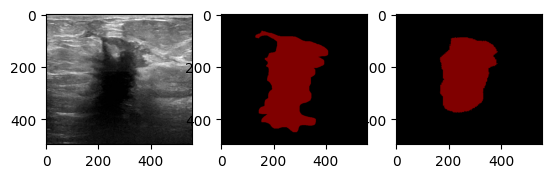

0.7122922421087925
0.9222132531004623
./Dataset_BUSI_with_GT/benign/benign (369).png


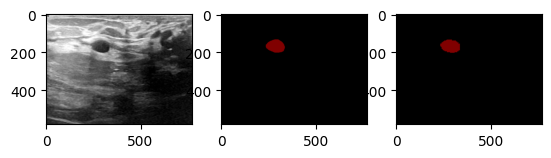

0.9030082987551867
0.9987345170073244
./Dataset_BUSI_with_GT/malignant/malignant (24).png


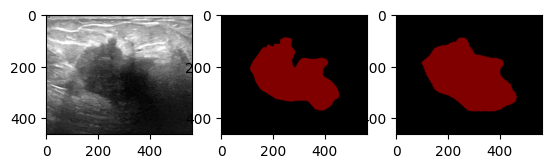

0.8503938221557716
0.9527451715458356
./Dataset_BUSI_with_GT/benign/benign (160).png


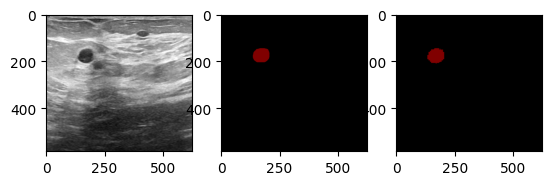

0.8983315954118873
0.9989214422805688
./Dataset_BUSI_with_GT/benign/benign (35).png


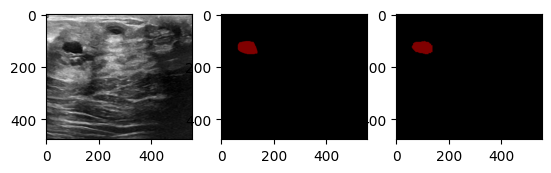

0.8832817337461301
0.9985599859436294
./Dataset_BUSI_with_GT/benign/benign (187).png


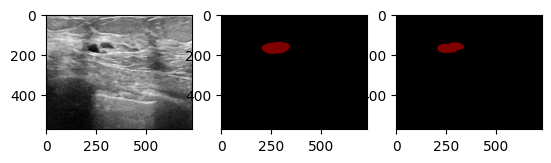

0.8083814151229881
0.9969494508044554
./Dataset_BUSI_with_GT/malignant/malignant (172).png


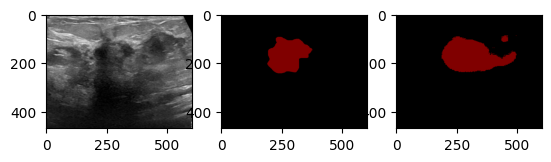

0.5957005340317698
0.9551175304446332
./Dataset_BUSI_with_GT/benign/benign (284).png


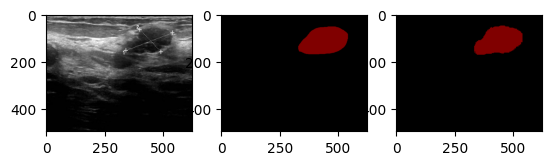

0.9123118252318921
0.9940577395366411
./Dataset_BUSI_with_GT/benign/benign (37).png


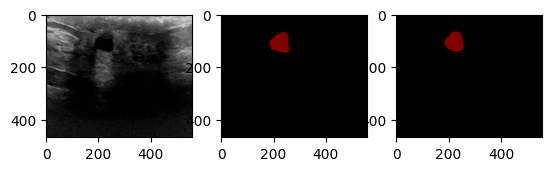

0.8235172127747823
0.996684910695156
./Dataset_BUSI_with_GT/benign/benign (241).png


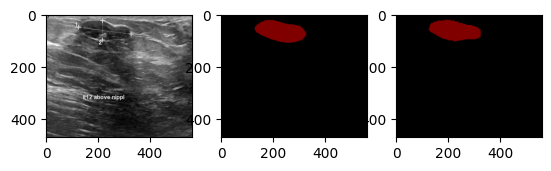

0.8895686025264161
0.9945168734344491
./Dataset_BUSI_with_GT/benign/benign (324).png


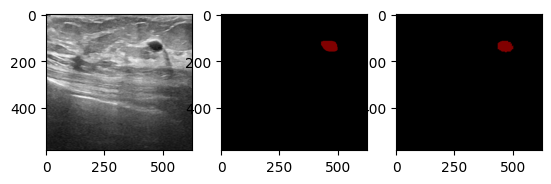

0.8483047885354771
0.9988028609967148
./Dataset_BUSI_with_GT/benign/benign (7).png


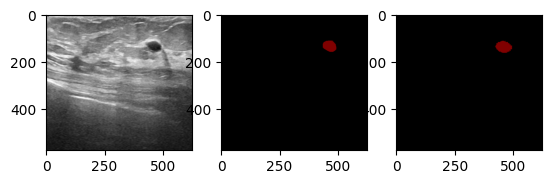

0.7308650765396938
0.9978919131445908
./Dataset_BUSI_with_GT/malignant/malignant (36).png


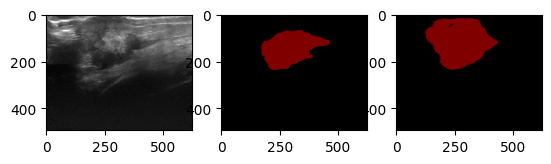

0.6046354540465234
0.9328957645153663
./Dataset_BUSI_with_GT/benign/benign (169).png


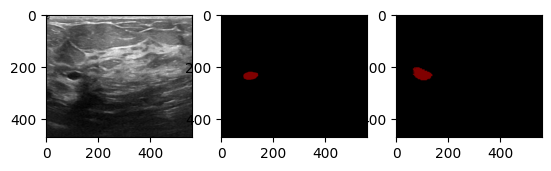

0.4962121212121212
0.9949197666912403
./Dataset_BUSI_with_GT/malignant/malignant (64).png


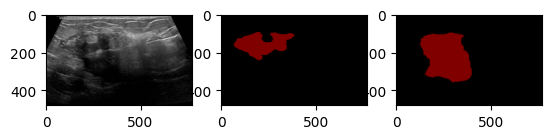

0.3422621086524628
0.8902128048850213
./Dataset_BUSI_with_GT/benign/benign (215).png


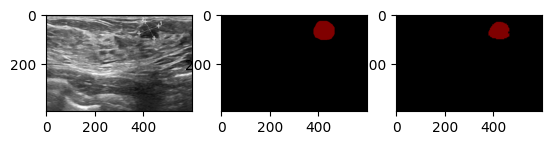

0.8544169611307421
0.9964599336667183
./Dataset_BUSI_with_GT/malignant/malignant (7).png


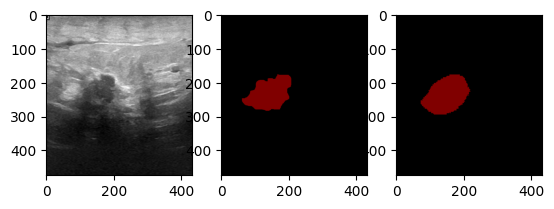

0.7653234272793346
0.9851196419701881
./Dataset_BUSI_with_GT/benign/benign (157).png


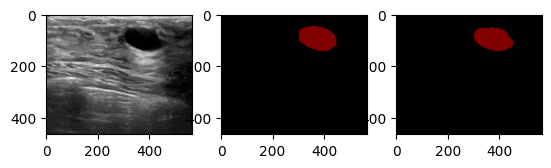

0.9012680367293397
0.995543696639813
./Dataset_BUSI_with_GT/benign/benign (336).png


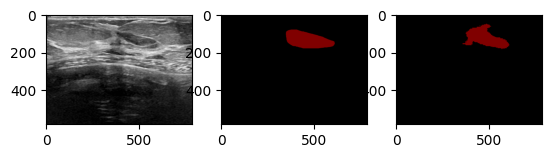

0.616973217166828
0.9813142750482942
./Dataset_BUSI_with_GT/benign/benign (428).png


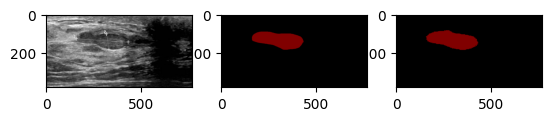

0.8851181761137837
0.9920637500857924
./Dataset_BUSI_with_GT/benign/benign (417).png


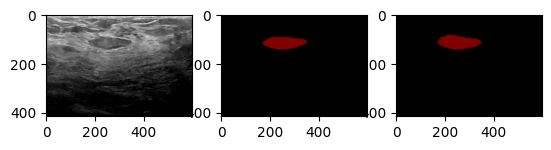

0.8582278481012658
0.9953796141977855
./Dataset_BUSI_with_GT/benign/benign (436).png


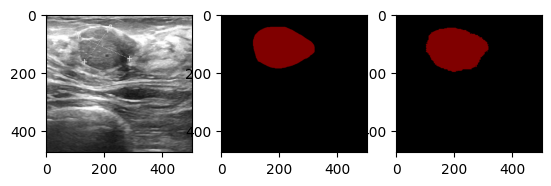

0.873773630055037
0.9853498673850555
./Dataset_BUSI_with_GT/malignant/malignant (93).png


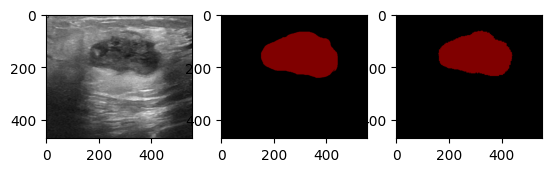

0.9126231592329695
0.9853976797404426
./Dataset_BUSI_with_GT/benign/benign (141).png


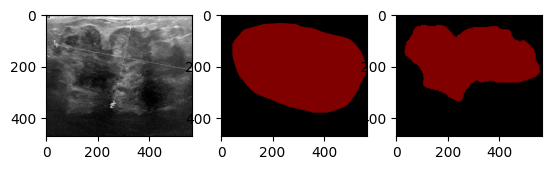

0.7068899070783197
0.7555488098851847
./Dataset_BUSI_with_GT/benign/benign (420).png


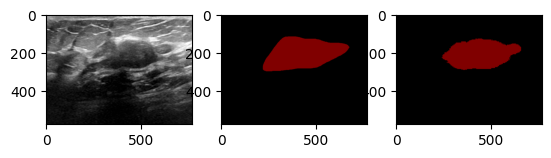

0.8109958981039734
0.9728040733094373
./Dataset_BUSI_with_GT/benign/benign (243).png


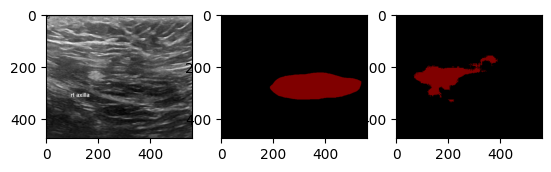

0.0283922867620963
0.8445408532176428
./Dataset_BUSI_with_GT/benign/benign (265).png


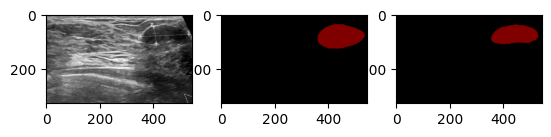

0.7753207973529175
0.9835095513105286
./Dataset_BUSI_with_GT/malignant/malignant (55).png


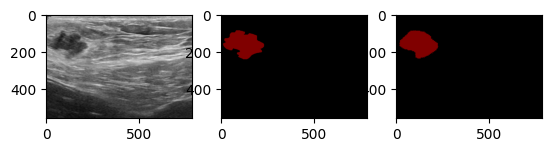

0.8645842861062837
0.9929181485299359
./Dataset_BUSI_with_GT/benign/benign (64).png


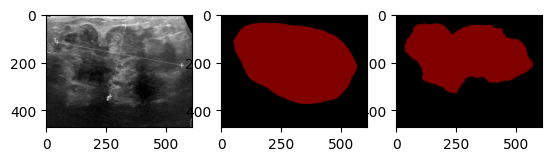

0.7528486346780537
0.8234037769784173
./Dataset_BUSI_with_GT/malignant/malignant (45).png


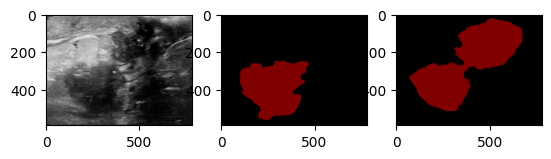

0.3970214600815947
0.7741731117532044
./Dataset_BUSI_with_GT/malignant/malignant (128).png


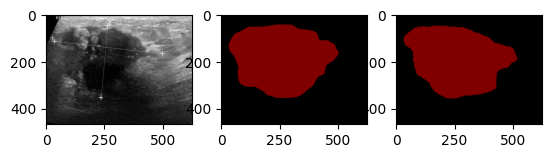

0.8615123801026099
0.9207894011615445
./Dataset_BUSI_with_GT/benign/benign (387).png


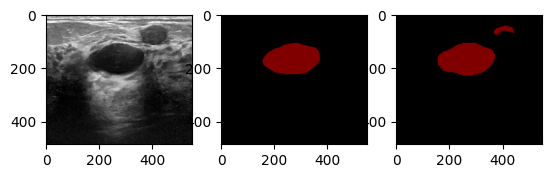

0.8703243044039064
0.9886455766151314
./Dataset_BUSI_with_GT/benign/benign (99).png


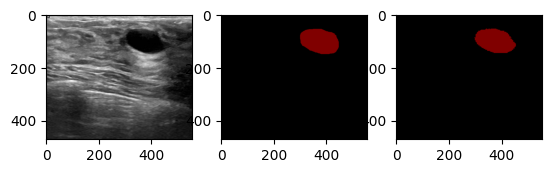

0.9167764024229655
0.9962154328898044
./Dataset_BUSI_with_GT/malignant/malignant (28).png


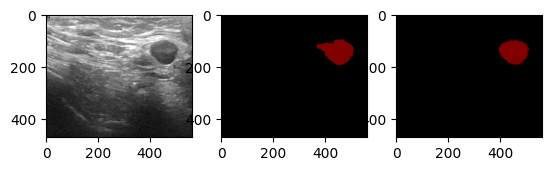

0.8547516793304702
0.9948552527908011
./Dataset_BUSI_with_GT/benign/benign (24).png


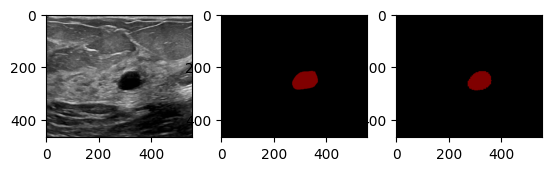

0.869150626876214
0.9970910375691909
./Dataset_BUSI_with_GT/benign/benign (30).png


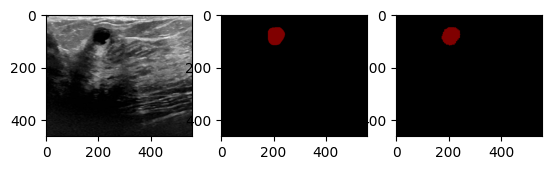

0.9192156862745098
0.9987825922511406
./Dataset_BUSI_with_GT/benign/benign (411).png


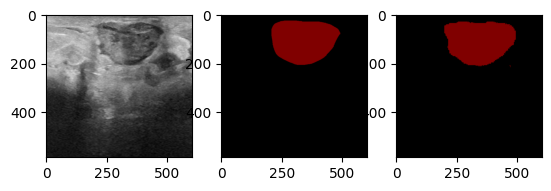

0.9163081645466595
0.9885371213810237
./Dataset_BUSI_with_GT/benign/benign (402).png


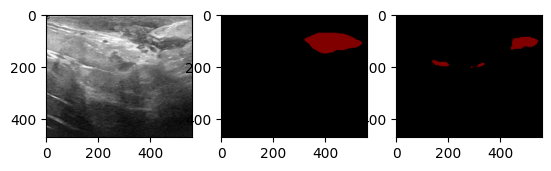

0.24732600732600732
0.9604439944096438
./Dataset_BUSI_with_GT/benign/benign (364).png


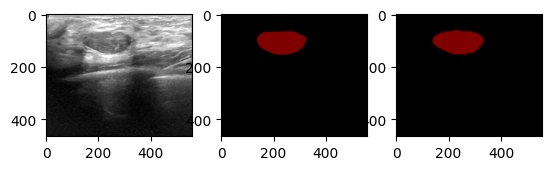

0.8752763957987839
0.9926726692593104
./Dataset_BUSI_with_GT/malignant/malignant (210).png


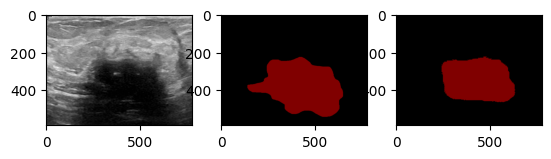

0.6816011262675266
0.9126675381127192
./Dataset_BUSI_with_GT/benign/benign (144).png


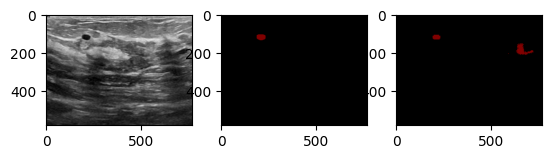

0.24878048780487805
0.9937803187025727
./Dataset_BUSI_with_GT/malignant/malignant (157).png


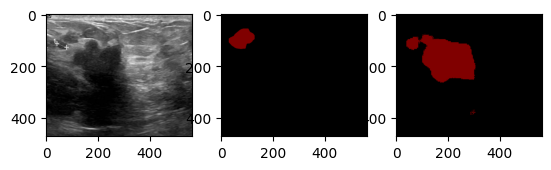

0.08307568637150631
0.8872173016881088
./Dataset_BUSI_with_GT/benign/benign (213).png


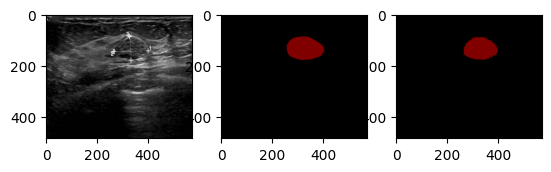

0.8622482745580032
0.9945908419278432
./Dataset_BUSI_with_GT/benign/benign (290).png


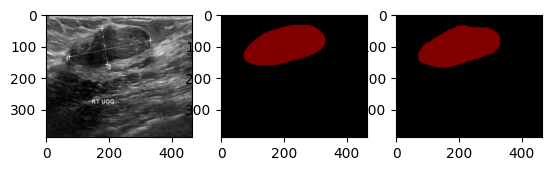

0.914785373608903
0.9864191196498363
./Dataset_BUSI_with_GT/malignant/malignant (188).png


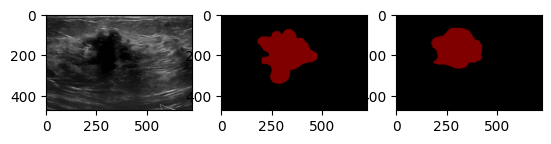

0.6800955121533092
0.9492928495639347
./Dataset_BUSI_with_GT/benign/benign (253).png


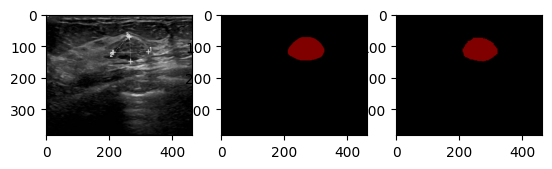

0.874800290486565
0.9949680688358843
./Dataset_BUSI_with_GT/malignant/malignant (152).png


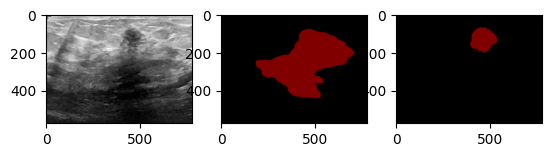

0.12502690348566683
0.802938426914421
./Dataset_BUSI_with_GT/malignant/malignant (190).png


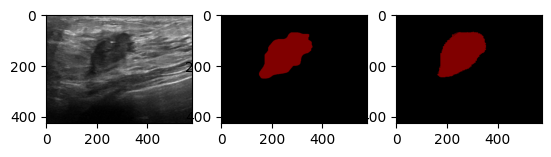

0.8694670280036134
0.9858570939197516
./Dataset_BUSI_with_GT/benign/benign (285).png


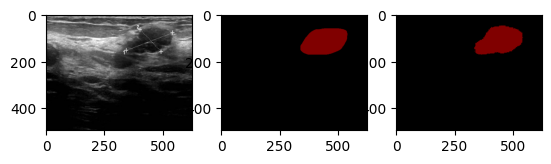

0.8684547925534642
0.9912102146558105
./Dataset_BUSI_with_GT/benign/benign (108).png


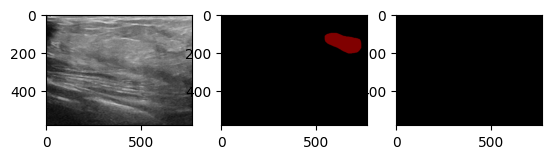

0.0
0.9690386497392517
./Dataset_BUSI_with_GT/benign/benign (173).png


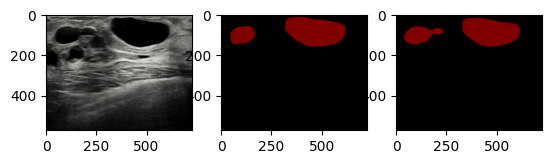

0.8757819481680071
0.9852440830365342
./Dataset_BUSI_with_GT/benign/benign (432).png


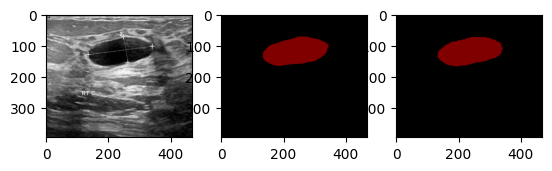

0.9467969598262758
0.9954107496165868
./Dataset_BUSI_with_GT/malignant/malignant (150).png


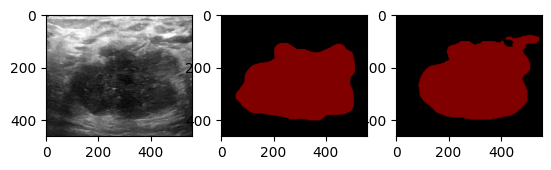

0.853192387487314
0.8996525347772171
./Dataset_BUSI_with_GT/benign/benign (238).png


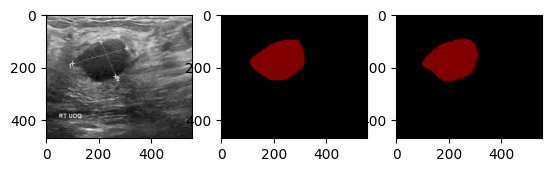

0.887438306002229
0.9881409665028431
./Dataset_BUSI_with_GT/malignant/malignant (202).png


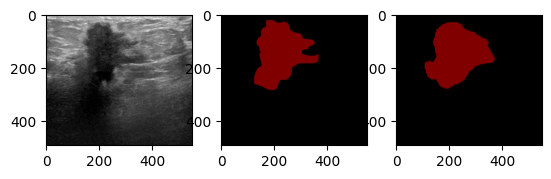

0.827324886445135
0.9693216617185476
./Dataset_BUSI_with_GT/malignant/malignant (46).png


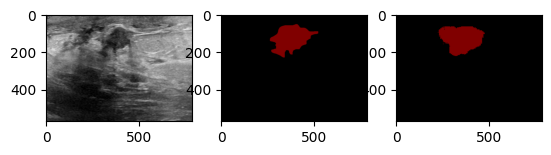

0.7168374913489108
0.9798538749402088
./Dataset_BUSI_with_GT/benign/benign (67).png


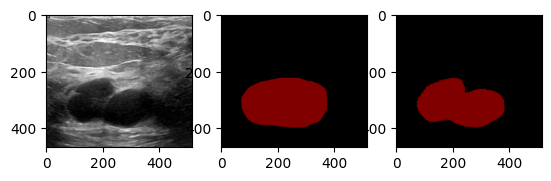

0.8245200853181657
0.9612581059736488
./Dataset_BUSI_with_GT/benign/benign (156).png


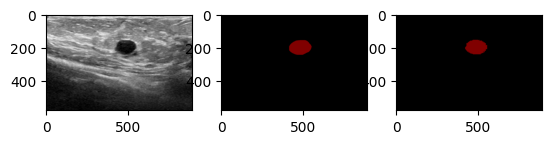

0.8638941398865785
0.9972999857893989
./Dataset_BUSI_with_GT/malignant/malignant (148).png


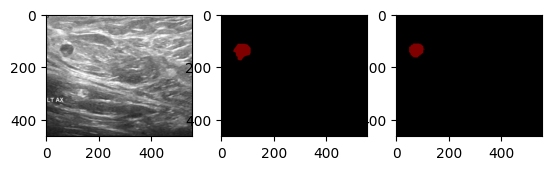

0.7548953409858203
0.9971550832314493
./Dataset_BUSI_with_GT/benign/benign (220).png


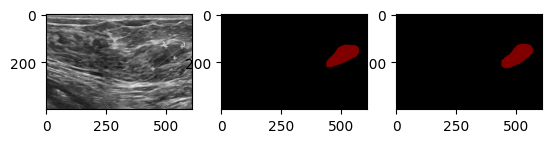

0.8497446252524052
0.9945942481090552
./Dataset_BUSI_with_GT/malignant/malignant (165).png


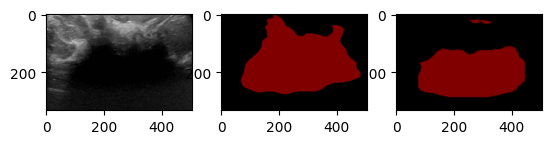

0.613279132791328
0.7505597775872546
./Dataset_BUSI_with_GT/benign/benign (76).png


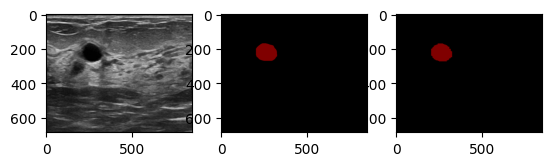

0.9349857006673022
0.9988057547909895
./Dataset_BUSI_with_GT/malignant/malignant (131).png


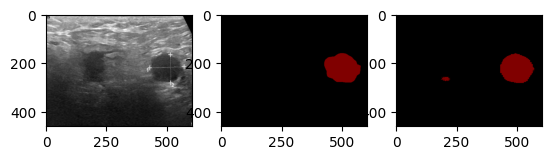

0.8554647248746308
0.9920899579309075
average tumor IoU: 0.7282782334239816
average background IoU: 0.9637655411017869


In [8]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/UNetVGG16.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor).squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))